# TFM - Evaluación de varias CNNs
## Ismael Franco Hernando
#### Imports

In [2]:
from tensorflow import keras
from mysql.connector import (connection)
import pandas as pd
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Reshape, Conv2D, MaxPooling2D, Concatenate, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
import matplotlib.pyplot as plt
import os

#### Conexión con la base de datos

In [3]:
try:
    cnx = connection.MySQLConnection(user='leer', 
                                     password='candanal',
                                     host='138.100.82.178',
                                     database='deepquality_tmp')

except mysql.connector.Error as err:
    if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Usuario o contraseña incorrecto")
    elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("La base de datos no existe")
    else:
        print(err)

In [4]:
# Guardamos y mostramos las bobinas 
q01 = "SELECT * FROM FEATURES_1D"
fea1D = pd.read_sql(q01,cnx)
fea1D

,COILID,MID,ZNMAX_FAILURES,ZNMIN_FAILURES,CALIBRATED,TOTAL_TILEID,L_DIS,R_DIS,MAP,DECISSION_OP
0,225216688,123.0,0,6,0,26,13,12,"[-1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1...",OK
1,225216688,124.0,4,0,0,26,3,6,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",OK
2,225216688,201.0,1,1,0,26,3,4,"[-1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",OK
3,225216688,202.0,1,1,0,26,13,13,"[1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...",OK
4,225220725,123.0,2,5,0,54,17,27,"[1, 1, 1, 1, 0, 1, 0, 0, 0, 0, -1, 0, -1, 0, -...",OK
...,...,...,...,...,...,...,...,...,...,...
4635,233652453,202.0,2,0,0,16,8,8,"[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]",OK
4636,233667056,123.0,1,0,0,26,13,13,"[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",OK
4637,233667056,124.0,1,1,0,26,13,13,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...",OK
4638,233667056,201.0,1,0,0,26,13,13,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...",OK


In [5]:
# Guardamos y mostramos las bobinas 
q02 = "SELECT * FROM FEATURES_2D"
fea2D = pd.read_sql(q02,cnx)
fea2D

,COILID,MID,ZNMAX_FAILURES,ZNMIN_FAILURES,CALIBRATED,TOTAL_TILEID,L_DIS,R_DIS,MAP,DECISSION_OP
0,225216688,1234.0,7,61,0,576,288,282,"[0, 0, -1, 0, 0, -1, -1, -1, -1, 0, 0, -1, -1,...",OK
1,225216688,1243.0,56,46,0,576,288,286,"[0, 0, -1, -1, 1, 0, 0, 1, 1, 0, 0, -1, -1, 1,...",OK
2,225220725,1234.0,105,30,0,1197,590,598,"[-1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1...",OK
3,225220725,1243.0,77,25,0,1197,595,595,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",OK
4,225221499,1234.0,10,65,0,720,360,360,"[1, 1, 1, 1, 1, 0, 0, -1, -1, 1, 1, 1, 1, 1, 0...",OK
...,...,...,...,...,...,...,...,...,...,...
2315,233651834,1243.0,5,80,0,729,364,364,"[0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,...",OK
2316,233652453,1234.0,10,18,0,351,175,175,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",OK
2317,233652453,1243.0,32,22,0,351,172,172,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",OK
2318,233667056,1234.0,9,3,0,576,288,288,"[0, 0, 0, 0, 1, 1, 0, 0, -1, 0, 0, 0, 0, 0, 0,...",OK


In [6]:
# Se cierra la conexión con la base de datos
cnx.close()

#### Preprocesamiento de los datos

In [7]:
def unionMapas1D(datos):
    bobinas = datos['COILID'].unique()
    sensores = [(123.0, 124.0), (201.0, 202.0)]
    X = np.zeros(int(len(datos)/2)).tolist()
    Y = []
    contadorID = 0
    
    for bob in bobinas:
        for s in sensores:
            mapa1 = datos.loc[datos['COILID']==bob].loc[datos['MID']==s[0]].MAP.iloc[0]      
            mapa1 = np.array(mapa1[1:-1].split(',')).astype(int)
            mapa2 = datos.loc[datos['COILID']==bob].loc[datos['MID']==s[1]].MAP.iloc[0]      
            mapa2 = np.array(mapa2[1:-1].split(',')).astype(int)
            X[contadorID] = np.concatenate((mapa1, mapa2), axis=0)
            Y.append(datos.loc[datos['COILID']==bob].DECISSION_OP.iloc[0])
            contadorID+=1
            
    return X,Y      

In [8]:
Xori,Yori = unionMapas1D(fea1D)

In [9]:
def normalizaData(datos):
    datosNormalizados = (datos - datos.min())/(datos.max() - datos.min()).tolist()
    unionCaras = []
    
    for i in range(0, len(datosNormalizados), 2):
        cara1 = datosNormalizados[i]
        cara2 = datosNormalizados[i + 1]
        unionCaras.append(np.concatenate((cara1,cara2), axis=0))
        
    return unionCaras
    

In [10]:
XNorm = normalizaData(fea1D.iloc[:, 2:8].values)

In [11]:
def separaMuestra(X, XNorm, Y, tam_muestraOK=50, tam_muestraNOK=150):
    muestraXOK = []
    muestraYOK = []
    muestraXNOK = []
    muestraYNOK = []
    muestraXNormOK = []
    muestraXNormNOK = []

    # Se recorren los valores de manera inversa, para no tener problema con las posiciones
    for i in reversed(range(len(Y))):
        # Label de la posición i
        label = Y[i]

        # Comprobamos si la label es OK y si no se han añadido suficientes valores a la muestra
        if (label == 'OK') and (len(muestraYOK)<tam_muestraOK):
            # Se añaden los valores X e Y a la muestra
            muestraYOK.append(label)
            muestraXOK.append(X[i])
            muestraXNormOK.append(XNorm[i])
            # Se eliminan de los datos originales
            X.pop(i)
            Y.pop(i)
            XNorm.pop(i)

        # Comprobamos si la label es NOK y si no se han añadido suficientes valores a la muestra
        elif (label == 'NOK') and (len(muestraYNOK)<tam_muestraNOK):
            # Se añaden los valores X e Y a la muestra
            muestraYNOK.append(label)
            muestraXNOK.append(X[i])
            muestraXNormNOK.append(XNorm[i])
            # Se eliminan de los datos originales
            X.pop(i)
            Y.pop(i)
            XNorm.pop(i)

        # Se comprueba si ya se cuenta con suficientes datos y se hace un break del for
        elif (len(muestraYNOK) == tam_muestraNOK) and (len(muestraYOK) == tam_muestraOK):
            break
            
            
    # Se unen las muestras de OK y NOK
    muestraX = muestraXOK + muestraXNOK
    muestraY = muestraYOK + muestraYNOK
    muestraXNorm = muestraXNormOK + muestraXNormNOK
    
    return muestraX, muestraY, muestraXNorm, X, Y, XNorm
    

In [12]:
muestraX, muestraY, muestraXNorm, X, Y, XNorm = separaMuestra(Xori, XNorm, Yori)

In [13]:
def preprocesado(X,Y, maxLongitud=None, overSampl=False):
    flag = False
    if maxLongitud is None:
        flag = True
        longitudes = []
        for x in X:
            longitudes.append(len(x))

        maxLongitud = max(longitudes)
    
    nuevoX = []
    for x in X:
        nuevoX.append(np.pad(x, (0,maxLongitud-len(x)), 'constant', constant_values= 0))        
    
    
    nuevoY = []
    for y in Y:
        if y == 'OK':
            nuevoY.append(0)
        else:
            nuevoY.append(1) 

    Y = nuevoY
    
    if overSampl:        
        sm = SMOTE()
        X, Y = sm.fit_resample(nuevoX, Y)
        X = np.expand_dims(X, axis=-1)
    else:
        X = np.expand_dims(nuevoX, axis=-1)
    
    if flag:
        return maxLongitud, X, Y
    else:
        return X, Y

In [14]:
maxLongitud, X, Y = preprocesado(X,Y,overSampl=True)

In [15]:
maxLongitud, Xori, Yori = preprocesado(Xori,Yori)

In [16]:
muestraX, muestraY = preprocesado(muestraX,muestraY,maxLongitud)

In [17]:
def modeloCV(X, Y, muestraX, muestraY, maxLongitud, filters=[32], kernel=3, epochs=300, batch_size=100, denso = [32, 8, 1]):
    # Validación cruzada de 5 modelos
    kfold = KFold(5)
    
    os.makedirs('tmp/checkpoint', exist_ok=True)
    filepath="tmp/checkpoint/best.hdf5"
    
    # Contador del número de modelo que se esta construyendo
    kContador = 1
    # Listas que contendrán los modelos generados junto con su historial
    modelos = []
    historial = []

    for train, test in kfold.split(X, Y):        
        modelo = Sequential();
        
        primero = True
        for f in filters:
            if primero:
                modelo.add(Conv1D(f, kernel, activation='relu', input_shape=(maxLongitud, 1)))
                primero = False
            else:
                modelo.add(Conv1D(f, kernel, activation='relu'))
                
        modelo.add(MaxPooling1D(2))
        modelo.add(Flatten())
        for d in denso:
            modelo.add(Dense(d, activation='relu'))        

        # Se compila el modelo
        modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])    
        checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
        # Se entrena el modelo y se guarda el histotial y el modelo
        proceso = modelo.fit(X[train], Y[train], epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[checkpoint])
        historial.append(proceso)
        modelo.load_weights(filepath)
        modelos.append(modelo)

        # Se evalua el modelo y se muestra
        resultado  = modelo.evaluate(muestraX,  muestraY, verbose=0)
        print("\nModelo", kContador)
        print("\nEl test loss obtenido ha sido:", resultado[0])
        print("La precisión obtenida ha sido:", resultado[1])

        # Se incrementa en 1 el contador de modelos
        kContador+=1
        
    
    return modelos, historial

In [18]:
def modeloCVNorm(X, XNorm, Y, muestraX, muestraXNorm, muestraY, maxLongitud, 
                 filters=[32], kernel=3, epochs=300, batch_size=100, denso = [32, 8, 1]):
    # Validación cruzada de 5 modelos
    kfold = KFold(5)
    
    os.makedirs('tmp/checkpoint', exist_ok=True)
    filepath="tmp/checkpoint/best.hdf5"
    
    # Contador del número de modelo que se esta construyendo
    kContador = 1
    # Listas que contendrán los modelos generados junto con su historial
    modelos = []
    historial = []

    for train, test in kfold.split(X, Y):
        inputs1 = Input(shape= (maxLongitud, 1))
        
        primero = True
        for f in filters:
            if primero:
                conv1 = Conv1D(f, kernel, activation='relu')(inputs1)
                primero = False
            else:
                conv1 = Conv1D(f, kernel, activation='relu')(conv1)
        
        pool1 = MaxPooling1D(2)(conv1)
        flat1 = Flatten()(pool1)
        
        inputs2 = Input(shape= (12,))
        
        conca = Concatenate()([flat1, inputs2])
        
        primero = True
        for d in denso:
            if primero:
                output = Dense(d, activation='relu')(conca)
                primero = False
            else:
                output = Dense(d, activation='relu')(output)
        
        modelo = Model(inputs=[inputs1, inputs2], outputs=output)
        

        # Se compila el modelo
        modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])    
        checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
        # Se entrena el modelo y se guarda el histotial y el modelo
        proceso = modelo.fit([X[train], XNorm[train]], Y[train], epochs=epochs, batch_size=batch_size, 
                             verbose=0, callbacks=[checkpoint])
        historial.append(proceso)
        modelo.load_weights(filepath)
        modelos.append(modelo)

        # Se evalua el modelo y se muestra
        resultado  = modelo.evaluate([muestraX, muestraXNorm],  muestraY, verbose=0)
        print("\nModelo", kContador)
        print("\nEl test loss obtenido ha sido:", resultado[0])
        print("La precisión obtenida ha sido:", resultado[1])

        # Se incrementa en 1 el contador de modelos
        kContador+=1
        
    
    return modelos, historial

In [19]:
def evaluaModelo(modelos, muestraX, muestraY, criterio, mostrar=True):
    predicciones = np.zeros((len(muestraY),1))
    
    for m in modelos:
        predicciones = np.sum([predicciones, m.predict(muestraX)], axis=0)

    predicciones = predicciones/len(modelos)
    
    Yprocesada = []
    for y in predicciones:
        if y <= criterio:
            Yprocesada.append(0)
        else:
            Yprocesada.append(1)
    
    if mostrar:
        # Se muestra la matriz de confusión
        tn, fp, fn, tp = confusion_matrix(muestraY, Yprocesada).ravel()
        print("\nLa precisión obtenida ha sido", (tn+tp)/(tn+fp+fn+tp))
        print("La matriz de confusion obtenida es:\n", confusion_matrix(muestraY, Yprocesada))
    else:
        return Yprocesada

In [27]:
def curvasROC():
    modelos, historial = modeloCV(np.array(X), np.array(Y), muestraX, muestraY, maxLongitud)
    criterios = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]    
    fig, axs = plt.subplots(2, 3, figsize=(12, 10))
    
    
    for i, criterio in enumerate(criterios):
        predicciones = evaluaModelo(modelos, muestraX, muestraY, criterio, mostrar=False)
        fpr, tpr, thresholds = roc_curve(muestraY, predicciones,)
        roc_auc = auc(fpr, tpr)
        
        fila = i // 3
        col = i % 3
        
        axs[fila, col].plot(fpr, tpr, label='Curva ROC (AUC = %0.2f)' % roc_auc)
        axs[fila, col].plot([0, 1], [0, 1], '--', label='Clasificador aleatorio')
        axs[fila, col].set_xlabel('False Positive Rate')
        axs[fila, col].set_ylabel('True Positive Rate')
        axs[fila, col].set_title('Curva ROC (Criterio = %0.2f)' % criterio)
        axs[fila, col].legend(loc="lower right")

    plt.show()


Modelo 1

El test loss obtenido ha sido: 5.223139877319336
La precisión obtenida ha sido: 0.48

Modelo 2

El test loss obtenido ha sido: 6.29843204498291
La precisión obtenida ha sido: 0.48

Modelo 3

El test loss obtenido ha sido: 3.0855016708374023
La precisión obtenida ha sido: 0.56

Modelo 4

El test loss obtenido ha sido: 5.5906180572509765
La precisión obtenida ha sido: 0.475

Modelo 5

El test loss obtenido ha sido: 6.814328880310058
La precisión obtenida ha sido: 0.475


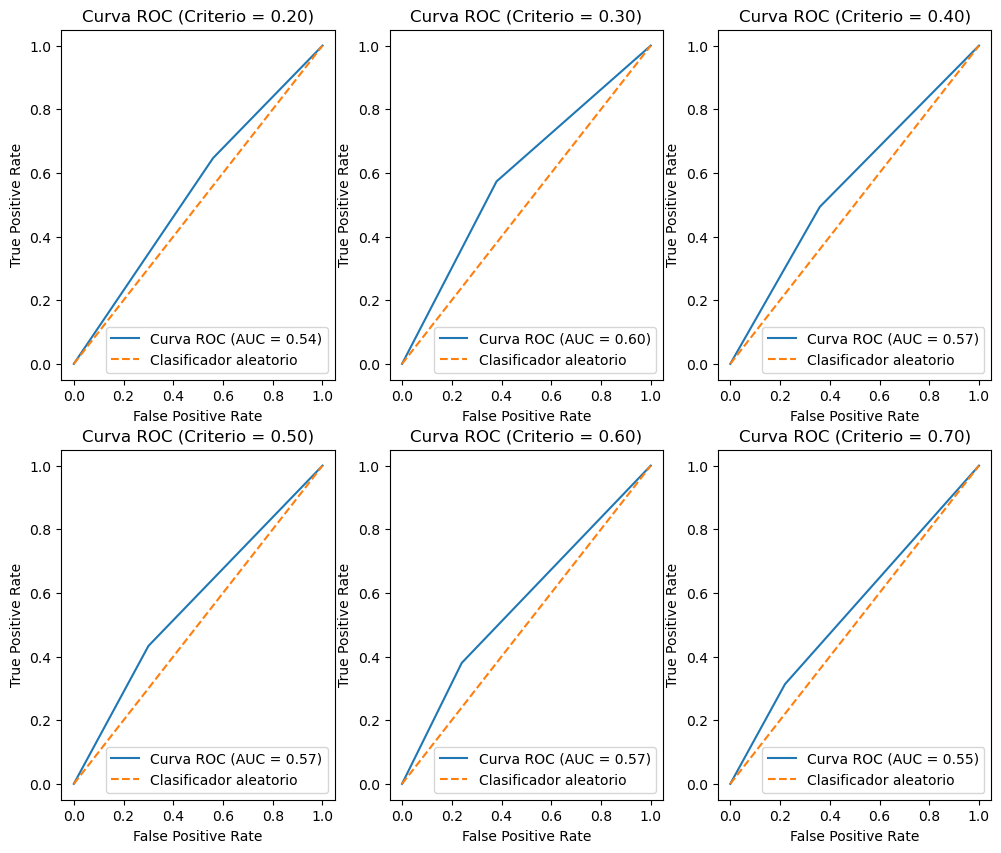

In [28]:
curvasROC()

In [20]:
def añadePrediccion(modelos, Xori, XNorm):
    copiaXnorm = np.copy(XNorm)
    datos = [np.array(Xori), np.array(XNorm)]
    for m in modelos:
        predic = m.predict(datos)        
        copiaXnorm = np.concatenate((copiaXnorm, predic), axis=1)
        
    return copiaXnorm

In [21]:
def creaRF(modelos, Xori, XNorm, Yori):
    Xtrain = np.array(Xori[:int(len(Xori)*0.8)])
    Xnormtrain = np.array(XNorm[:int(len(XNorm)*0.8)])
    Ytrain = Yori[:int(len(Yori)*0.8)]
    
    NormyPredi = añadePrediccion(modelos, Xtrain, Xnormtrain)
    
    rf = RandomForestClassifier()
    rf.fit(NormyPredi, Ytrain)
    
    return rf

In [22]:
def evaluaRF(rf, modelos, Xori, Xnorm ,muestraY):
    NormyPredi = añadePrediccion(modelos, Xori, Xnorm)
    predicc = rf.predict(NormyPredi)
    tn, fp, fn, tp = confusion_matrix(muestraY, predicc).ravel()
    print("\nLa precisión obtenida con el RF ha sido", (tn+tp)/(tn+fp+fn+tp))
    print("La matriz de confusion obtenida es:\n", confusion_matrix(muestraY, predicc))


### Experimentos 1D

#### Solo mapa de la bobina

In [23]:
modelos, historial = modeloCV(np.array(X), np.array(Y), muestraX, muestraY, maxLongitud)
evaluaModelo(modelos, muestraX, muestraY, criterio=0.3)


Modelo 1

El test loss obtenido ha sido: 6.088761558532715
La precisión obtenida ha sido: 0.45

Modelo 2

El test loss obtenido ha sido: 7.042691421508789
La precisión obtenida ha sido: 0.44

Modelo 3

El test loss obtenido ha sido: 5.848724021911621
La precisión obtenida ha sido: 0.51

Modelo 4

El test loss obtenido ha sido: 6.231250905990601
La precisión obtenida ha sido: 0.43

Modelo 5

El test loss obtenido ha sido: 6.495690956115722
La precisión obtenida ha sido: 0.425

La precisión obtenida ha sido 0.535
La matriz de confusion obtenida es:
 [[27 23]
 [70 80]]


In [24]:
modelos2, historial2 = modeloCV(np.array(X), np.array(Y), muestraX, muestraY, maxLongitud, epochs=500, kernel=5, filters=[64])
evaluaModelo(modelos2, muestraX, muestraY, criterio=0.3)


Modelo 1

El test loss obtenido ha sido: 6.400815734863281
La precisión obtenida ha sido: 0.49

Modelo 2

El test loss obtenido ha sido: 6.756723327636719
La precisión obtenida ha sido: 0.44

Modelo 3

El test loss obtenido ha sido: 5.0982294845581055
La precisión obtenida ha sido: 0.525

Modelo 4

El test loss obtenido ha sido: 6.2990380382537845
La precisión obtenida ha sido: 0.475

Modelo 5

El test loss obtenido ha sido: 5.358199167251587
La precisión obtenida ha sido: 0.48

La precisión obtenida ha sido 0.54
La matriz de confusion obtenida es:
 [[30 20]
 [72 78]]


In [25]:
modelos3, historial3 = modeloCV(np.array(X), np.array(Y), muestraX, muestraY, maxLongitud, filters=[16], denso=[64, 32, 16, 8 ,1])
evaluaModelo(modelos3, muestraX, muestraY, criterio=0.3)


Modelo 1

El test loss obtenido ha sido: 7.447497100830078
La precisión obtenida ha sido: 0.435

Modelo 2

El test loss obtenido ha sido: 7.609405021667481
La precisión obtenida ha sido: 0.41

Modelo 3

El test loss obtenido ha sido: 6.54843921661377
La precisión obtenida ha sido: 0.5

Modelo 4

El test loss obtenido ha sido: 5.899940109252929
La precisión obtenida ha sido: 0.46

Modelo 5

El test loss obtenido ha sido: 6.262682723999023
La precisión obtenida ha sido: 0.49

La precisión obtenida ha sido 0.54
La matriz de confusion obtenida es:
 [[29 21]
 [71 79]]


In [26]:
modelos4, historial4 = modeloCV(np.array(X), np.array(Y), muestraX, muestraY, maxLongitud, kernel=5, filters=[16])
evaluaModelo(modelos4, muestraX, muestraY, criterio=0.3)


Modelo 1

El test loss obtenido ha sido: 5.896213836669922
La precisión obtenida ha sido: 0.53

Modelo 2

El test loss obtenido ha sido: 7.364962959289551
La precisión obtenida ha sido: 0.445

Modelo 3

El test loss obtenido ha sido: 6.6239281845092775
La precisión obtenida ha sido: 0.52

Modelo 4

El test loss obtenido ha sido: 6.503459434509278
La precisión obtenida ha sido: 0.485

Modelo 5

El test loss obtenido ha sido: 6.482871353626251
La precisión obtenida ha sido: 0.465

La precisión obtenida ha sido 0.56
La matriz de confusion obtenida es:
 [[29 21]
 [67 83]]


In [27]:
modelos5, historial5 = modeloCV(np.array(X), np.array(Y), muestraX, muestraY, maxLongitud, filters=[16, 32, 64])
evaluaModelo(modelos5, muestraX, muestraY, criterio=0.3)


Modelo 1

El test loss obtenido ha sido: 6.547582283020019
La precisión obtenida ha sido: 0.485

Modelo 2

El test loss obtenido ha sido: 6.418758430480957
La precisión obtenida ha sido: 0.47

Modelo 3

El test loss obtenido ha sido: 6.314342079162597
La precisión obtenida ha sido: 0.52

Modelo 4

El test loss obtenido ha sido: 6.531701202392578
La precisión obtenida ha sido: 0.485

Modelo 5

El test loss obtenido ha sido: 6.967323951721191
La precisión obtenida ha sido: 0.445

La precisión obtenida ha sido 0.57
La matriz de confusion obtenida es:
 [[32 18]
 [68 82]]


In [29]:
modelos6, historial6 = modeloCV(np.array(X), np.array(Y), muestraX, muestraY, maxLongitud, filters=[16, 32, 64], epochs=500)
evaluaModelo(modelos6, muestraX, muestraY, criterio=0.3)


Modelo 1

El test loss obtenido ha sido: 7.208371887207031
La precisión obtenida ha sido: 0.43

Modelo 2

El test loss obtenido ha sido: 7.7452342987060545
La precisión obtenida ha sido: 0.42

Modelo 3

El test loss obtenido ha sido: 5.75803726196289
La precisión obtenida ha sido: 0.52

Modelo 4

El test loss obtenido ha sido: 6.5470634460449215
La precisión obtenida ha sido: 0.45

Modelo 5

El test loss obtenido ha sido: 6.5741944503784175
La precisión obtenida ha sido: 0.465

La precisión obtenida ha sido 0.56
La matriz de confusion obtenida es:
 [[30 20]
 [68 82]]


In [30]:
modelos7, historial7 = modeloCV(np.array(X), np.array(Y), muestraX, muestraY, maxLongitud, filters=[16, 32, 64], kernel = 5)
evaluaModelo(modelos7, muestraX, muestraY, criterio=0.3)


Modelo 1

El test loss obtenido ha sido: 5.673856468200683
La precisión obtenida ha sido: 0.465

Modelo 2

El test loss obtenido ha sido: 7.998211631774902
La precisión obtenida ha sido: 0.385

Modelo 3

El test loss obtenido ha sido: 5.830532989501953
La precisión obtenida ha sido: 0.505

Modelo 4

El test loss obtenido ha sido: 6.646613349914551
La precisión obtenida ha sido: 0.43

Modelo 5

El test loss obtenido ha sido: 5.121591720581055
La precisión obtenida ha sido: 0.47

La precisión obtenida ha sido 0.505
La matriz de confusion obtenida es:
 [[26 24]
 [75 75]]


#### Mapa de la bobina + Atributos normalizados

In [26]:
modelosNorm1, historialNorm1 = modeloCVNorm(np.array(Xori), np.array(XNorm), np.array(Yori), np.array(muestraX), 
                                       np.array(muestraXNorm), muestraY, maxLongitud)
evaluaModelo(modelosNorm1, [np.array(muestraX), np.array(muestraXNorm)], muestraY, criterio=0.3)
rf = creaRF(modelosNorm1, Xori, XNorm, Yori)
evaluaRF(rf, modelosNorm1, muestraX, muestraXNorm ,muestraY)


Modelo 1

El test loss obtenido ha sido: 11.56871150970459
La precisión obtenida ha sido: 0.25

Modelo 2

El test loss obtenido ha sido: 6.213968086242676
La precisión obtenida ha sido: 0.39

Modelo 3

El test loss obtenido ha sido: 7.48933443069458
La precisión obtenida ha sido: 0.415

Modelo 4

El test loss obtenido ha sido: 6.600860729217529
La precisión obtenida ha sido: 0.395

Modelo 5

El test loss obtenido ha sido: 6.413043441772461
La precisión obtenida ha sido: 0.475

La precisión obtenida ha sido 0.47
La matriz de confusion obtenida es:
 [[35 15]
 [91 59]]

La precisión obtenida con el RF ha sido 0.475
La matriz de confusion obtenida es:
 [[38 12]
 [93 57]]


In [27]:
modelosNorm2, historialNorm2 = modeloCVNorm(np.array(Xori), np.array(XNorm), np.array(Yori), np.array(muestraX), 
                                       np.array(muestraXNorm), muestraY, maxLongitud, kernel=5, filters=[16])
evaluaModelo(modelosNorm2, [np.array(muestraX), np.array(muestraXNorm)], muestraY, criterio=0.3)
rf = creaRF(modelosNorm2, Xori, XNorm, Yori)
evaluaRF(rf, modelosNorm2, muestraX, muestraXNorm ,muestraY)


Modelo 1

El test loss obtenido ha sido: 5.60698184967041
La precisión obtenida ha sido: 0.455

Modelo 2

El test loss obtenido ha sido: 7.161399154663086
La precisión obtenida ha sido: 0.405

Modelo 3

El test loss obtenido ha sido: 6.760846843719483
La precisión obtenida ha sido: 0.44

Modelo 4

El test loss obtenido ha sido: 7.27698579788208
La precisión obtenida ha sido: 0.39

Modelo 5

El test loss obtenido ha sido: 6.689235153198243
La precisión obtenida ha sido: 0.435

La precisión obtenida ha sido 0.51
La matriz de confusion obtenida es:
 [[33 17]
 [81 69]]

La precisión obtenida con el RF ha sido 0.445
La matriz de confusion obtenida es:
 [[38 12]
 [99 51]]


In [28]:
modelosNorm3, historialNorm3 = modeloCVNorm(np.array(Xori), np.array(XNorm), np.array(Yori), np.array(muestraX), 
                                       np.array(muestraXNorm), muestraY, maxLongitud, kernel=5, filters=[64])
evaluaModelo(modelosNorm3, [np.array(muestraX), np.array(muestraXNorm)], muestraY, criterio=0.3)
rf = creaRF(modelosNorm3, Xori, XNorm, Yori)
evaluaRF(rf, modelosNorm3, muestraX, muestraXNorm ,muestraY)


Modelo 1

El test loss obtenido ha sido: 5.260654258728027
La precisión obtenida ha sido: 0.455

Modelo 2

El test loss obtenido ha sido: 11.56871150970459
La precisión obtenida ha sido: 0.25

Modelo 3

El test loss obtenido ha sido: 7.617159290313721
La precisión obtenida ha sido: 0.36

Modelo 4

El test loss obtenido ha sido: 6.725423221588135
La precisión obtenida ha sido: 0.38

Modelo 5

El test loss obtenido ha sido: 6.309779930114746
La precisión obtenida ha sido: 0.435

La precisión obtenida ha sido 0.485
La matriz de confusion obtenida es:
 [[39 11]
 [92 58]]

La precisión obtenida con el RF ha sido 0.46
La matriz de confusion obtenida es:
 [[40 10]
 [98 52]]


In [29]:
modelosNorm4, historialNorm4 = modeloCVNorm(np.array(Xori), np.array(XNorm), np.array(Yori), np.array(muestraX), 
                                       np.array(muestraXNorm), muestraY, maxLongitud, filters=[16])
evaluaModelo(modelosNorm4, [np.array(muestraX), np.array(muestraXNorm)], muestraY, criterio=0.3)
rf = creaRF(modelosNorm4, Xori, XNorm, Yori)
evaluaRF(rf, modelosNorm4, muestraX, muestraXNorm ,muestraY)


Modelo 1

El test loss obtenido ha sido: 5.746805095672608
La precisión obtenida ha sido: 0.515

Modelo 2

El test loss obtenido ha sido: 6.068878650665283
La precisión obtenida ha sido: 0.43

Modelo 3

El test loss obtenido ha sido: 7.425830166339875
La precisión obtenida ha sido: 0.41

Modelo 4

El test loss obtenido ha sido: 11.56871150970459
La precisión obtenida ha sido: 0.25

Modelo 5

El test loss obtenido ha sido: 6.661786041259766
La precisión obtenida ha sido: 0.47

La precisión obtenida ha sido 0.525
La matriz de confusion obtenida es:
 [[35 15]
 [80 70]]

La precisión obtenida con el RF ha sido 0.47
La matriz de confusion obtenida es:
 [[35 15]
 [91 59]]


In [30]:
modelosNorm5, historialNorm5 = modeloCVNorm(np.array(Xori), np.array(XNorm), np.array(Yori), np.array(muestraX), 
                                       np.array(muestraXNorm), muestraY, maxLongitud, denso=[64, 32, 16, 8 ,1])
evaluaModelo(modelosNorm5, [np.array(muestraX), np.array(muestraXNorm)], muestraY, criterio=0.3)
rf = creaRF(modelosNorm5, Xori, XNorm, Yori)
evaluaRF(rf, modelosNorm5, muestraX, muestraXNorm ,muestraY)


Modelo 1

El test loss obtenido ha sido: 7.438733520507813
La precisión obtenida ha sido: 0.385

Modelo 2

El test loss obtenido ha sido: 7.044715690612793
La precisión obtenida ha sido: 0.415

Modelo 3

El test loss obtenido ha sido: 7.6703033447265625
La precisión obtenida ha sido: 0.43

Modelo 4

El test loss obtenido ha sido: 11.56871150970459
La precisión obtenida ha sido: 0.25

Modelo 5

El test loss obtenido ha sido: 6.317013874053955
La precisión obtenida ha sido: 0.45

La precisión obtenida ha sido 0.475
La matriz de confusion obtenida es:
 [[34 16]
 [89 61]]

La precisión obtenida con el RF ha sido 0.455
La matriz de confusion obtenida es:
 [[40 10]
 [99 51]]


In [31]:
modelosNorm6, historialNorm6 = modeloCVNorm(np.array(Xori), np.array(XNorm), np.array(Yori), np.array(muestraX), 
                                       np.array(muestraXNorm), muestraY, maxLongitud, filters=[32,64])
evaluaModelo(modelosNorm6, [np.array(muestraX), np.array(muestraXNorm)], muestraY, criterio=0.3)
rf = creaRF(modelosNorm6, Xori, XNorm, Yori)
evaluaRF(rf, modelosNorm6, muestraX, muestraXNorm ,muestraY)


Modelo 1

El test loss obtenido ha sido: 6.055081262588501
La precisión obtenida ha sido: 0.41

Modelo 2

El test loss obtenido ha sido: 6.189607191085815
La precisión obtenida ha sido: 0.445

Modelo 3

El test loss obtenido ha sido: 6.9803446412086485
La precisión obtenida ha sido: 0.41

Modelo 4

El test loss obtenido ha sido: 7.223389358520508
La precisión obtenida ha sido: 0.4

Modelo 5

El test loss obtenido ha sido: 6.534396095275879
La precisión obtenida ha sido: 0.46

La precisión obtenida ha sido 0.48
La matriz de confusion obtenida es:
 [[31 19]
 [85 65]]

La precisión obtenida con el RF ha sido 0.455
La matriz de confusion obtenida es:
 [[31 19]
 [90 60]]


In [32]:
modelosNorm7, historialNorm7 = modeloCVNorm(np.array(Xori), np.array(XNorm), np.array(Yori), np.array(muestraX), 
                                       np.array(muestraXNorm), muestraY, maxLongitud, kernel=5, filters=[32,64])
evaluaModelo(modelosNorm7, [np.array(muestraX), np.array(muestraXNorm)], muestraY, criterio=0.3)
rf = creaRF(modelosNorm7, Xori, XNorm, Yori)
evaluaRF(rf, modelosNorm7, muestraX, muestraXNorm ,muestraY)


Modelo 1

El test loss obtenido ha sido: 6.490344734191894
La precisión obtenida ha sido: 0.44

Modelo 2

El test loss obtenido ha sido: 11.56871150970459
La precisión obtenida ha sido: 0.25

Modelo 3

El test loss obtenido ha sido: 7.957765130996704
La precisión obtenida ha sido: 0.425

Modelo 4

El test loss obtenido ha sido: 7.034594211578369
La precisión obtenida ha sido: 0.4

Modelo 5

El test loss obtenido ha sido: 11.56871150970459
La precisión obtenida ha sido: 0.25

La precisión obtenida ha sido 0.425
La matriz de confusion obtenida es:
 [[ 39  11]
 [104  46]]

La precisión obtenida con el RF ha sido 0.435
La matriz de confusion obtenida es:
 [[ 43   7]
 [106  44]]


### Experimentos 2D

In [33]:
def mapa2D(datos):
    bobinas = datos['COILID'].unique()
    sensores = [1234.0, 1243.0]
    X = np.zeros(len(datos)).tolist()
    Y = []
    contadorID = 0
    
    for bob in bobinas:
        for s in sensores:
            mapa = datos.loc[datos['COILID']==bob].loc[datos['MID']==s].MAP.iloc[0]
            mapa = np.array(mapa[1:-1].split(',')).astype(int)
            X[contadorID] = mapa
            Y.append(datos.loc[datos['COILID']==bob].DECISSION_OP.iloc[0])
            contadorID+=1
            
    return X,Y    

In [34]:
X2ori,Y2ori = mapa2D(fea2D)

In [35]:
def normalizaData2D(datos):
    return (datos - datos.min())/(datos.max() - datos.min()).tolist()

In [36]:
XNorm2 = normalizaData2D(fea2D.iloc[:, 2:8].values)

In [37]:
muestraX2, muestraY2, muestraXNorm2, X2, Y2, XNorm2 = separaMuestra(X2ori, XNorm2.tolist(), Y2ori)

In [38]:
def preprocesado2D(X,Y, maxLongitud=None, overSampl=False):
    flag = False
    if maxLongitud is None:
        flag = True
        longitudes = []
        for x in X:
            longitudes.append(len(x))

        maxLongitud = max(longitudes)
    
    nuevoX = []
    for x in X:
        nuevoX.append(np.pad(x, (0,maxLongitud-len(x)), 'constant', constant_values= 0).reshape(9, -1, order='F'))        
    
    X = nuevoX
    nuevoY = []
    for y in Y:
        if y == 'OK':
            nuevoY.append(0)
        else:
            nuevoY.append(1) 

    Y = nuevoY  
   
    
    if flag:
        return maxLongitud, np.array(X), Y
    else:
        return np.array(X), Y

In [39]:
maxLongitud, X2, Y2 = preprocesado2D(X2,Y2,overSampl=False)

In [40]:
muestraX2, muestraY2 = preprocesado2D(muestraX2,muestraY2, maxLongitud)

In [41]:
def modelo2DCV(X, Y, muestraX, muestraY, maxLongitud, filters=[32], kernel=(3,3), 
               epochs=100, batch_size=50, denso = [32, 8, 1]):
    # Validación cruzada de 5 modelos
    kfold = KFold(5)
    
    os.makedirs('tmp/checkpoint', exist_ok=True)
    filepath="tmp/checkpoint/best.hdf5"
    
    # Contador del número de modelo que se esta construyendo
    kContador = 1
    # Listas que contendrán los modelos generados junto con su historial
    modelos = []
    historial = []

    for train, test in kfold.split(X, Y):        
        modelo = Sequential()
        modelo.add(Reshape((9, int(maxLongitud/9), 1), input_shape=(9, int(maxLongitud/9))))
        for f in filters:
            modelo.add(Conv2D(f, kernel, activation='relu'))
        modelo.add(MaxPooling2D((2,2)))
        modelo.add(Flatten())
        for d in denso:
            modelo.add(Dense(d, activation='relu'))

        # Se compila el modelo
        modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])    
        checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
        # Se entrena el modelo y se guarda el histotial y el modelo
        proceso = modelo.fit(X[train], Y[train], epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[checkpoint])
        historial.append(proceso)
        modelo.load_weights(filepath)
        modelos.append(modelo)

        # Se evalua el modelo y se muestra
        resultado  = modelo.evaluate(muestraX,  muestraY, verbose=0)
        print("\nModelo", kContador)
        print("\nEl test loss obtenido ha sido:", resultado[0])
        print("La precisión obtenida ha sido:", resultado[1])

        # Se incrementa en 1 el contador de modelos
        kContador+=1
        
    
    return modelos, historial

In [42]:
def modelo2DCVNorm(X, XNorm, Y, muestraX, muestraXNorm, muestraY, maxLongitud, 
                 filters=[32], kernel=(3,3), epochs=100, batch_size=50, denso = [32, 8, 1]):
    # Validación cruzada de 5 modelos
    kfold = KFold(5)
    
    os.makedirs('tmp/checkpoint', exist_ok=True)
    filepath="tmp/checkpoint/best.hdf5"
    
    # Contador del número de modelo que se esta construyendo
    kContador = 1
    # Listas que contendrán los modelos generados junto con su historial
    modelos = []
    historial = []

    for train, test in kfold.split(X, Y):
        inputs1 = Input(shape=(9, int(maxLongitud/9)))
        res1 = Reshape((9, int(maxLongitud/9), 1))(inputs1)
        
        primero = True
        for f in filters:
            if primero:
                conv2d1 = Conv2D(f, kernel, activation='relu')(res1)
                primero = False
            else:
                conv2d1 = Conv2D(f, kernel, activation='relu')(conv2d1)
        
        pool1 = MaxPooling2D((2,2))(conv2d1)
        flat1 = Flatten()(pool1)
        
        inputs2 = Input(shape= (6,))
        
        conca = Concatenate()([flat1, inputs2])
        
        primero = True
        for d in denso:
            if primero:
                output = Dense(d, activation='relu')(conca)
                primero = False
            else:
                output = Dense(d, activation='relu')(output)       
        
        modelo = Model(inputs=[inputs1, inputs2], outputs=output)
        

        # Se compila el modelo
        modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])    
        checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
        # Se entrena el modelo y se guarda el histotial y el modelo
        proceso = modelo.fit([X[train], XNorm[train]], Y[train], epochs=epochs, batch_size=batch_size, 
                             verbose=0, callbacks=[checkpoint])
        historial.append(proceso)
        modelo.load_weights(filepath)
        modelos.append(modelo)

        # Se evalua el modelo y se muestra
        resultado  = modelo.evaluate([muestraX, muestraXNorm],  muestraY, verbose=0)
        print("\nModelo", kContador)
        print("\nEl test loss obtenido ha sido:", resultado[0])
        print("La precisión obtenida ha sido:", resultado[1])

        # Se incrementa en 1 el contador de modelos
        kContador+=1
        
    
    return modelos, historial

In [44]:
modelos8, historial8 = modelo2DCV(X2, np.array(Y2), muestraX2, muestraY2, maxLongitud)
evaluaModelo(modelos8, muestraX2, muestraY2, criterio=0.3)


Modelo 1

El test loss obtenido ha sido: 5.910637578964233
La precisión obtenida ha sido: 0.46

Modelo 2

El test loss obtenido ha sido: 6.251842060089111
La precisión obtenida ha sido: 0.475

Modelo 3

El test loss obtenido ha sido: 10.116465015411377
La precisión obtenida ha sido: 0.28

Modelo 4

El test loss obtenido ha sido: 5.922926158905029
La precisión obtenida ha sido: 0.455

Modelo 5

El test loss obtenido ha sido: 5.092081279754638
La precisión obtenida ha sido: 0.53

La precisión obtenida ha sido 0.485
La matriz de confusion obtenida es:
 [[37 13]
 [90 60]]


In [45]:
modelos9, historial9 = modelo2DCV(X2, np.array(Y2), muestraX2, muestraY2, maxLongitud, filters=[16])
evaluaModelo(modelos9, muestraX2, muestraY2, criterio=0.3)


Modelo 1

El test loss obtenido ha sido: 5.315322399139404
La precisión obtenida ha sido: 0.45

Modelo 2

El test loss obtenido ha sido: 6.8406494522094725
La precisión obtenida ha sido: 0.435

Modelo 3

El test loss obtenido ha sido: 7.124287528991699
La precisión obtenida ha sido: 0.42

Modelo 4

El test loss obtenido ha sido: 6.52895071029663
La precisión obtenida ha sido: 0.43

Modelo 5

El test loss obtenido ha sido: 5.283186664581299
La precisión obtenida ha sido: 0.49

La precisión obtenida ha sido 0.49
La matriz de confusion obtenida es:
 [[37 13]
 [89 61]]


In [46]:
modelos10, historial10 = modelo2DCV(X2, np.array(Y2), muestraX2, muestraY2, maxLongitud, kernel=(5,5))
evaluaModelo(modelos10, muestraX2, muestraY2, criterio=0.3)


Modelo 1

El test loss obtenido ha sido: 5.8179349613189695
La precisión obtenida ha sido: 0.465

Modelo 2

El test loss obtenido ha sido: 4.85850581407547
La precisión obtenida ha sido: 0.48

Modelo 3

El test loss obtenido ha sido: 3.8848984336853025
La precisión obtenida ha sido: 0.395

Modelo 4

El test loss obtenido ha sido: 2.7941946601867675
La precisión obtenida ha sido: 0.445

Modelo 5

El test loss obtenido ha sido: 5.023856601715088
La precisión obtenida ha sido: 0.54

La precisión obtenida ha sido 0.525
La matriz de confusion obtenida es:
 [[34 16]
 [79 71]]


In [47]:
modelos11, historial11 = modelo2DCV(X2, np.array(Y2), muestraX2, muestraY2, maxLongitud, filters=[64], denso=[64, 32, 16, 8 ,1])
evaluaModelo(modelos11, muestraX2, muestraY2, criterio=0.3)


Modelo 1

El test loss obtenido ha sido: 11.56871150970459
La precisión obtenida ha sido: 0.25

Modelo 2

El test loss obtenido ha sido: 7.0338232421875
La precisión obtenida ha sido: 0.425

Modelo 3

El test loss obtenido ha sido: 6.309259090423584
La precisión obtenida ha sido: 0.4

Modelo 4

El test loss obtenido ha sido: 5.6630302429199215
La precisión obtenida ha sido: 0.44

Modelo 5

El test loss obtenido ha sido: 5.554764528274536
La precisión obtenida ha sido: 0.535

La precisión obtenida ha sido 0.53
La matriz de confusion obtenida es:
 [[41  9]
 [85 65]]


In [48]:
modelos12, historial12 = modelo2DCV(X2, np.array(Y2), muestraX2, muestraY2, maxLongitud, filters=[16], kernel=(5,5))
evaluaModelo(modelos12, muestraX2, muestraY2, criterio=0.3)


Modelo 1

El test loss obtenido ha sido: 6.276072835922241
La precisión obtenida ha sido: 0.425

Modelo 2

El test loss obtenido ha sido: 6.646888885498047
La precisión obtenida ha sido: 0.45

Modelo 3

El test loss obtenido ha sido: 11.56871150970459
La precisión obtenida ha sido: 0.25

Modelo 4

El test loss obtenido ha sido: 5.264121646881104
La precisión obtenida ha sido: 0.44

Modelo 5

El test loss obtenido ha sido: 5.668335342407227
La precisión obtenida ha sido: 0.52

La precisión obtenida ha sido 0.495
La matriz de confusion obtenida es:
 [[38 12]
 [89 61]]


In [45]:
modelos13, historial13 = modelo2DCV(X2, np.array(Y2), muestraX2, muestraY2, maxLongitud, filters=[16, 32])
evaluaModelo(modelos13, muestraX2, muestraY2, criterio=0.3)


Modelo 1

El test loss obtenido ha sido: 6.656743459701538
La precisión obtenida ha sido: 0.46

Modelo 2

El test loss obtenido ha sido: 6.561233940124512
La precisión obtenida ha sido: 0.42

Modelo 3

El test loss obtenido ha sido: 7.920607032775879
La precisión obtenida ha sido: 0.37

Modelo 4

El test loss obtenido ha sido: 6.097616195678711
La precisión obtenida ha sido: 0.415

Modelo 5

El test loss obtenido ha sido: 5.523863563537597
La precisión obtenida ha sido: 0.51

La precisión obtenida ha sido 0.49
La matriz de confusion obtenida es:
 [[36 14]
 [88 62]]


In [47]:
modelos14, historial14 = modelo2DCV(X2, np.array(Y2), muestraX2, muestraY2, maxLongitud, filters=[16, 32, 64])
evaluaModelo(modelos14, muestraX2, muestraY2, criterio=0.3)


Modelo 1

El test loss obtenido ha sido: 6.425687942504883
La precisión obtenida ha sido: 0.41

Modelo 2

El test loss obtenido ha sido: 6.681940250396728
La precisión obtenida ha sido: 0.435

Modelo 3

El test loss obtenido ha sido: 7.942205963134765
La precisión obtenida ha sido: 0.395

Modelo 4

El test loss obtenido ha sido: 7.044237289428711
La precisión obtenida ha sido: 0.44

Modelo 5

El test loss obtenido ha sido: 5.127728824615478
La precisión obtenida ha sido: 0.54

La precisión obtenida ha sido 0.54
La matriz de confusion obtenida es:
 [[34 16]
 [76 74]]


#### Mapa de la bobina + Atributos normalizados

In [45]:
modelosNorm8, historialNorm8 = modelo2DCVNorm(np.array(X2), np.array(XNorm2), np.array(Y2), np.array(muestraX2), 
                                       np.array(muestraXNorm2), muestraY2, maxLongitud)
evaluaModelo(modelosNorm8, [np.array(muestraX2), np.array(muestraXNorm2)], muestraY2, criterio=0.3)
rf = creaRF(modelosNorm8, X2, XNorm2, Y2)
evaluaRF(rf, modelosNorm8, muestraX2, muestraXNorm2 ,muestraY2)


Modelo 1

El test loss obtenido ha sido: 4.756995580196381
La precisión obtenida ha sido: 0.47

Modelo 2

El test loss obtenido ha sido: 5.617926425933838
La precisión obtenida ha sido: 0.455

Modelo 3

El test loss obtenido ha sido: 11.56871150970459
La precisión obtenida ha sido: 0.25

Modelo 4

El test loss obtenido ha sido: 5.654583415985107
La precisión obtenida ha sido: 0.455

Modelo 5

El test loss obtenido ha sido: 5.495919580459595
La precisión obtenida ha sido: 0.505

La precisión obtenida ha sido 0.51
La matriz de confusion obtenida es:
 [[41  9]
 [89 61]]

La precisión obtenida con el RF ha sido 0.5
La matriz de confusion obtenida es:
 [[42  8]
 [92 58]]


In [46]:
modelosNorm9, historialNorm9 = modelo2DCVNorm(np.array(X2), np.array(XNorm2), np.array(Y2), np.array(muestraX2), 
                                       np.array(muestraXNorm2), muestraY2, maxLongitud, filters=[16], kernel=(5,5))
evaluaModelo(modelosNorm9, [np.array(muestraX2), np.array(muestraXNorm2)], muestraY2, criterio=0.3)
rf = creaRF(modelosNorm9, X2, XNorm2, Y2)
evaluaRF(rf, modelosNorm9, muestraX2, muestraXNorm2 ,muestraY2)


Modelo 1

El test loss obtenido ha sido: 5.2200103282928465
La precisión obtenida ha sido: 0.495

Modelo 2

El test loss obtenido ha sido: 5.346688356399536
La precisión obtenida ha sido: 0.495

Modelo 3

El test loss obtenido ha sido: 5.501474723815918
La precisión obtenida ha sido: 0.395

Modelo 4

El test loss obtenido ha sido: 7.003958282470703
La precisión obtenida ha sido: 0.405

Modelo 5

El test loss obtenido ha sido: 4.814532928466797
La precisión obtenida ha sido: 0.545

La precisión obtenida ha sido 0.505
La matriz de confusion obtenida es:
 [[30 20]
 [79 71]]

La precisión obtenida con el RF ha sido 0.53
La matriz de confusion obtenida es:
 [[39 11]
 [83 67]]


In [47]:
modelosNorm10, historialNorm10 = modelo2DCVNorm(np.array(X2), np.array(XNorm2), np.array(Y2), np.array(muestraX2), 
                                       np.array(muestraXNorm2), muestraY2, maxLongitud, kernel=(5,5))
evaluaModelo(modelosNorm10, [np.array(muestraX2), np.array(muestraXNorm2)], muestraY2, criterio=0.3)
rf = creaRF(modelosNorm10, X2, XNorm2, Y2)
evaluaRF(rf, modelosNorm10, muestraX2, muestraXNorm2 ,muestraY2)


Modelo 1

El test loss obtenido ha sido: 5.276276779174805
La precisión obtenida ha sido: 0.445

Modelo 2

El test loss obtenido ha sido: 6.156191720962524
La precisión obtenida ha sido: 0.46

Modelo 3

El test loss obtenido ha sido: 6.030296058654785
La precisión obtenida ha sido: 0.43

Modelo 4

El test loss obtenido ha sido: 5.29969144821167
La precisión obtenida ha sido: 0.43

Modelo 5

El test loss obtenido ha sido: 5.283025741577148
La precisión obtenida ha sido: 0.51

La precisión obtenida ha sido 0.525
La matriz de confusion obtenida es:
 [[34 16]
 [79 71]]

La precisión obtenida con el RF ha sido 0.51
La matriz de confusion obtenida es:
 [[42  8]
 [90 60]]


In [48]:
modelosNorm11, historialNorm11 = modelo2DCVNorm(np.array(X2), np.array(XNorm2), np.array(Y2), np.array(muestraX2), 
                                       np.array(muestraXNorm2), muestraY2, maxLongitud, filters=[16])
evaluaModelo(modelosNorm11, [np.array(muestraX2), np.array(muestraXNorm2)], muestraY2, criterio=0.3)
rf = creaRF(modelosNorm11, X2, XNorm2, Y2)
evaluaRF(rf, modelosNorm11, muestraX2, muestraXNorm2 ,muestraY2)


Modelo 1

El test loss obtenido ha sido: 6.101791877746582
La precisión obtenida ha sido: 0.44

Modelo 2

El test loss obtenido ha sido: 5.702147665023804
La precisión obtenida ha sido: 0.455

Modelo 3

El test loss obtenido ha sido: 5.942756824493408
La precisión obtenida ha sido: 0.35

Modelo 4

El test loss obtenido ha sido: 6.162562198638916
La precisión obtenida ha sido: 0.455

Modelo 5

El test loss obtenido ha sido: 11.56871150970459
La precisión obtenida ha sido: 0.25

La precisión obtenida ha sido 0.49
La matriz de confusion obtenida es:
 [[40 10]
 [92 58]]

La precisión obtenida con el RF ha sido 0.47
La matriz de confusion obtenida es:
 [[43  7]
 [99 51]]


In [49]:
modelosNorm12, historialNorm12 = modelo2DCVNorm(np.array(X2), np.array(XNorm2), np.array(Y2), np.array(muestraX2), 
                                       np.array(muestraXNorm2), muestraY2, maxLongitud, denso=[64, 32, 16, 8 ,1])
evaluaModelo(modelosNorm12, [np.array(muestraX2), np.array(muestraXNorm2)], muestraY2, criterio=0.3)
rf = creaRF(modelosNorm12, X2, XNorm2, Y2)
evaluaRF(rf, modelosNorm12, muestraX2, muestraXNorm2 ,muestraY2)


Modelo 1

El test loss obtenido ha sido: 5.581670217514038
La precisión obtenida ha sido: 0.49

Modelo 2

El test loss obtenido ha sido: 6.32126630783081
La precisión obtenida ha sido: 0.47

Modelo 3

El test loss obtenido ha sido: 11.56871150970459
La precisión obtenida ha sido: 0.25

Modelo 4

El test loss obtenido ha sido: 5.9635703659057615
La precisión obtenida ha sido: 0.465

Modelo 5

El test loss obtenido ha sido: 5.717298431396484
La precisión obtenida ha sido: 0.485

La precisión obtenida ha sido 0.515
La matriz de confusion obtenida es:
 [[38 12]
 [85 65]]

La precisión obtenida con el RF ha sido 0.495
La matriz de confusion obtenida es:
 [[37 13]
 [88 62]]


In [50]:
modelosNorm13, historialNorm13 = modelo2DCVNorm(np.array(X2), np.array(XNorm2), np.array(Y2), np.array(muestraX2), 
                                       np.array(muestraXNorm2), muestraY2, maxLongitud, filters=[32, 16])
evaluaModelo(modelosNorm13, [np.array(muestraX2), np.array(muestraXNorm2)], muestraY2, criterio=0.3)
rf = creaRF(modelosNorm13, X2, XNorm2, Y2)
evaluaRF(rf, modelosNorm13, muestraX2, muestraXNorm2 ,muestraY2)


Modelo 1

El test loss obtenido ha sido: 5.8581093978881835
La precisión obtenida ha sido: 0.47

Modelo 2

El test loss obtenido ha sido: 11.56871150970459
La precisión obtenida ha sido: 0.25

Modelo 3

El test loss obtenido ha sido: 7.237797355651855
La precisión obtenida ha sido: 0.405

Modelo 4

El test loss obtenido ha sido: 7.546441650390625
La precisión obtenida ha sido: 0.415

Modelo 5

El test loss obtenido ha sido: 5.195712490081787
La precisión obtenida ha sido: 0.54

La precisión obtenida ha sido 0.51
La matriz de confusion obtenida es:
 [[35 15]
 [83 67]]

La precisión obtenida con el RF ha sido 0.515
La matriz de confusion obtenida es:
 [[42  8]
 [89 61]]


In [51]:
modelosNorm14, historialNorm14 = modelo2DCVNorm(np.array(X2), np.array(XNorm2), np.array(Y2), np.array(muestraX2), 
                                       np.array(muestraXNorm2), muestraY2, maxLongitud,filters=[16, 32, 64])
evaluaModelo(modelosNorm14, [np.array(muestraX2), np.array(muestraXNorm2)], muestraY2, criterio=0.3)
rf = creaRF(modelosNorm14, X2, XNorm2, Y2)
evaluaRF(rf, modelosNorm14, muestraX2, muestraXNorm2 ,muestraY2)


Modelo 1

El test loss obtenido ha sido: 6.603037009239197
La precisión obtenida ha sido: 0.415

Modelo 2

El test loss obtenido ha sido: 6.98616397857666
La precisión obtenida ha sido: 0.475

Modelo 3

El test loss obtenido ha sido: 11.56871150970459
La precisión obtenida ha sido: 0.25

Modelo 4

El test loss obtenido ha sido: 6.44680947303772
La precisión obtenida ha sido: 0.35

Modelo 5

El test loss obtenido ha sido: 2.2806212425231935
La precisión obtenida ha sido: 0.525

La precisión obtenida ha sido 0.49
La matriz de confusion obtenida es:
 [[39 11]
 [91 59]]

La precisión obtenida con el RF ha sido 0.475
La matriz de confusion obtenida es:
 [[42  8]
 [97 53]]


#### Guardar modelos obtenidos en los experimentos

In [55]:
# Se crean los directorios donde se van a guardar los modelos
os.makedirs('cnn/mapa', exist_ok=True)
os.makedirs('cnn/normalizado', exist_ok=True)

In [59]:
modelos_mapa = [modelos, modelos2, modelos3, modelos4, modelos5, modelos6, modelos7, 
                modelos8, modelos9, modelos10, modelos11, modelos12, modelos13, modelos14]
contador=1
for m in modelos_mapa:
    for i in range(len(m)):
        m[i].save('cnn/mapa/exp'+str(contador)+'modelo' + str(i+1))
        
    contador+=1

In [60]:
modelos_norma = [modelosNorm1, modelosNorm2, modelosNorm3, modelosNorm4, modelosNorm5, modelosNorm6, 
                 modelosNorm7, modelosNorm8, modelosNorm9, modelosNorm10, modelosNorm11, modelosNorm12,
                modelosNorm13, modelosNorm14]

contador=1
for m in modelos_mapa:
    for i in range(len(m)):
        m[i].save('cnn/normalizado/exp'+str(contador)+'modelo' + str(i+1))
        
    contador+=1